# 1. Set Up

In [1]:
!spack find -lvp tfel
!echo "$(spack find -p tfel | awk '/\/mofem_install\// {print $NF "/lib"}')"
# %env LD_LIBRARY_PATH=/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib

-- linux-ubuntu20.04-x86_64 / gcc@9.4.0 -------------------------
mvfpqw7 tfel@4.0.0+abaqus+ansys+aster+calculix+castem+comsol+cyrano+diana-fea+europlexus~fortran~ipo~java+lsdyna~python~python_bindings build_system=cmake build_type=Release generator=make  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx
jjcwdu6 tfel@4.0.0+abaqus+ansys+aster+calculix+castem+comsol+cyrano+diana-fea+europlexus~fortran~ipo~java+lsdyna+python+python_bindings build_system=cmake build_type=Release generator=make  /mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc
==> 2 installed packages
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-mvfpqw7u4c23su7hj7g4leuwmykrjmcx/lib
/mofem_install/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-9.4.0/tfel-4.0.0-jjcwdu6cbil5dzqzjhjekn3jdzo3e6gc/lib


In [2]:
import math
import os
import re
import sys
import time
import json
from pathlib import Path
import subprocess
import zipfile
import pydantic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv
import gmsh
# from scipy import optimize
# from scipy.optimize import curve_fit, least_squares

sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')

import setup
import core
import custom_models as cm
import utils as ut
import plotting
    


# 2. Simulation Parameters

In [ ]:
#in MPa
soil_model = cm.PropertyTypeEnum.elastic
# soil_model = cm.PropertyTypeEnum.cam_clay
def initialize_parameters() -> cm.AttrDict:
    params = cm.AttrDict()
    params.interface = False
    params.global_default_model = cm.PropertyTypeEnum.elastic
    params.pile_manager = cm.PileManager(x=0, y=0, z=10, dx=0, dy=0, dz=-20.5, R=1, r=0.975,
                                preferred_model= cm.PropertyTypeEnum.elastic,
                                props = {
                                    cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=200000, poisson_ratio=0.3),
                                },
                                interface = params.interface,
                                )

    soil_layer_1 = cm.SoilLayer(
        depth = -2,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.3,HardeningSlope = 10, YieldStress = 100),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=96, poisson_ratio=0.499, phi=np.radians(27), c=0, v=np.radians(27)),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    soil_layer_2 = cm.SoilLayer(
        depth = -1.4,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=182.1, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=182.1, poisson_ratio=0.3,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=182.1, poisson_ratio=0.499, phi=np.radians(27), c=0, v=np.radians(27)),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    soil_layer_3 = cm.SoilLayer(
        depth = -7.1,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=351.3, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=351.3, poisson_ratio=0.3,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=351.3, poisson_ratio=0.499, phi=np.radians(27), c=0, v=np.radians(27)),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
                 }, 
            )
    soil_layer_4 = cm.SoilLayer(
        depth = -29.5,
        preferred_model= params.global_default_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=668.4, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=668.4, poisson_ratio=0.3,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.499, phi=np.radians(27), c=0, v=np.radians(27)),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            }, 
            )
    params.interface_manager = cm.InterfaceManager(
        preferred_model = params.global_default_model,
        props = {
            cm.PropertyTypeEnum.elastic: cm.ElasticProperties(youngs_modulus=96, poisson_ratio=0.3),
            cm.PropertyTypeEnum.von_mises: cm.VonMisesProperties(youngs_modulus=96, poisson_ratio=0.499,HardeningSlope = 5000, YieldStress = 20),
            cm.PropertyTypeEnum.drucker_prager: cm.DruckerPragerProperties(youngs_modulus=668.4, poisson_ratio=0.499, phi=np.radians(27), c=0, v=np.radians(27)),
            cm.PropertyTypeEnum.cam_clay: cm.CamClayProperties(),
            },
            )
    # params.prescribed_force = cm.ForceBoundaryCondition(fx=0,fy=0,fz=0)
    params.prescribed_disp = cm.SurfaceBoundaryCondition(disp_ux=1, disp_uy=0 ,disp_uz=0)
    params.box_manager = cm.BoxManager(x=-80, y=-80, z=0, dx=160, dy=80,
        layers=[
        soil_layer_1,
        soil_layer_2,
        soil_layer_3,
        soil_layer_4,   
        ],
        far_field_size=5,
        near_field_dist=5,
        near_field_size=0.05,
    )

    params.nproc = 8 # number of processors/cores used
    params.order = 2 #order of approximation functions
    params.dim = 3
    
    params.final_time = 1 # [s]
    params.time_step = 1 / 5 # [s]
    params.case_name = "pile"
    params.wk_dir = Path(f"/mofem_install/jupyter/thomas/mfront_example_test")
    parasm.read_med_exe = "/mofem_install/jupyter/thomas/um_view/bin/read_med"
    params.h5m_to_vtk_converter = "/mofem_install/jupyter/thomas/um_view/bin/convert.py"
    params.partition_exe = "/mofem_install/jupyter/thomas/um_view/bin/mofem_part"
    params.exe = f"/mofem_install/jupyter/thomas/um_view/tutorials/adv-1/contact_3d"
    params.postprocessing_script = "/mofem_install/jupyter/thomas/mfront_example_test/src/pile_postprocessing.py"
    params.mode = "auto" # see 4. to see difference between auto and manual

    return params

In [4]:
params = initialize_parameters()

# 3. Log paths and meta

In [5]:
params = setup.setup(params)

Simulation #4 for the day.


# 4. Generate the mesh

In [6]:
core.generate_mesh(params)

╭────────────────╮
│  DRAWING MESH  │
╰────────────────╯
Done, taken Wall Time: 0.05 seconds, CPU Time: 0.05 seconds
╭────────────────────────────╮
│  CREATING PHYSICAL GROUPS  │
╰────────────────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭──────────────────────────────────╮
│  ADDING PHYSICAL GROUPS TO MESH  │
╰──────────────────────────────────╯
Done, taken Wall Time: 0.00 seconds, CPU Time: 0.00 seconds
╭───────────────────╮
│  GENERATING MESH  │
╰───────────────────╯


Done, taken Wall Time: 4.72 seconds, CPU Time: 4.70 seconds
╭──────────────────────╮
│  CHECKING BLOCK IDS  │
╰──────────────────────╯
{'pile': 1, 'CYLINDER': 2, 'FIX_ALL': 3, 'FIX_X_0': 4, 'FIX_X_1': 5, 'FIX_Y_0': 6, 'FIX_Z_0': 7, 'SOIL_LAYER_0': 8, 'SOIL_LAYER_1': 9, 'SOIL_LAYER_2': 10, 'SOIL_LAYER_3': 11}
Done, taken Wall Time: 0.60 seconds, CPU Time: 0.01 seconds
╭───────────────────────────╮
│  GENERATING CONFIG FILES  │
╰───────────────────────────╯
[PhysicalGroup(dim=3, tags=[1], name='SOIL_LAYER_0', meshnet_id=8, group_type=<PhysicalGroupType.MATERIAL: 1>, preferred_model=<PropertyTypeEnum.elastic: 'LinearElasticity'>, props={<PropertyTypeEnum.elastic: 'LinearElasticity'>: ElasticProperties(youngs_modulus=96.0, poisson_ratio=0.3), <PropertyTypeEnum.von_mises: 'VMSimo'>: VonMisesProperties(youngs_modulus=96.0, poisson_ratio=0.3, HardeningSlope=10.0, YieldStress=100.0), <PropertyTypeEnum.drucker_prager: 'DruckerPragerSimple'>: DruckerPragerProperties(youngs_modulus=96.0, poisson_

[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-6 12:8:10
[0] <inform> UTC time: 2024-11-6 12:8:10
[0] <inform> [MED] Reading MED file V4.1.0 using MED library V4.1.0
[0] <inform> [MED] Check mesh pile nsteps 1
[0] <inform> [MED] Reading mesh pile nsteps 1
[0] <inform> [MED] Read number of nodes 24334
[0] <inform> [MED] Reading elements 12077 of type Tri number of nodes 3
[0] <inform> [MED] Reading elements 94157 of type Tet number of nodes 4
[0] <inform> [read_med] Print all meshsets (old and added from meshsets configurational file)
[0] <inform> [read_med] meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name pile
[0] <inform> [read_med] meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name CYLINDER                       
[0] <inform> [read_med] meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_A

Done, taken Wall Time: 0.53 seconds, CPU Time: 0.00 seconds
╭─────────────────────────────────────╮
│  PARTITIONING MESH with mofem_part  │
╰─────────────────────────────────────╯


[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-6 12:8:11
[0] <inform> UTC time: 2024-11-6 12:8:11
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316737 type BLOCKSET UNKNOWNNAME msId 1 name pile
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 2 name CYLINDER                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 3 name FIX_ALL                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316741 type BLOCKSET UNKNOWNNAME msId 5 name FIX_X_1                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682

Done, taken Wall Time: 7.92 seconds, CPU Time: 0.01 seconds


{'interface': False,
 'pile_manager': PileManager(x=0.0, y=0.0, z=10.0, dx=0.0, dy=0.0, dz=-20.5, R=1.0, r=0.975, interface=False, preferred_model='LinearElasticity', props={'LinearElasticity': ElasticProperties(youngs_modulus=200000.0, poisson_ratio=0.3)}),
 'interface_manager': InterfaceManager(preferred_model=<PropertyTypeEnum.elastic: 'LinearElasticity'>, props={<PropertyTypeEnum.elastic: 'LinearElasticity'>: ElasticProperties(youngs_modulus=96.0, poisson_ratio=0.3), <PropertyTypeEnum.von_mises: 'VMSimo'>: VonMisesProperties(youngs_modulus=96.0, poisson_ratio=0.3, HardeningSlope=5000.0, YieldStress=20.0), <PropertyTypeEnum.drucker_prager: 'DruckerPragerSimple'>: DruckerPragerProperties(youngs_modulus=96.0, poisson_ratio=0.3, d=150.0, beta=0.6, pa=0.01, pb=0.05), <PropertyTypeEnum.cam_clay: 'ModCamClay_semiExpl'>: CamClayProperties(nu=0.3, M=1.2, la=0.077, ka=0.0066, v0=1.7857, pc0=400)}),
 'prescribed_disp': SurfaceBoundaryCondition(disp_ux=1.0, disp_uy=0.0, disp_uz=0.0),
 'box_man

# 5. Running the analysis and export to .vtk file format

In [7]:
core.mofem_compute(params)

╭─────────────╮
│  COMPUTING  │
╰─────────────╯
[0] <inform> MoFEM version 0.14.0 (MOAB 5.5.0 Petsc Release Version 3.16.6, Mar 30, 2022 )
[0] <inform> git commit id 693a01d8ad1e79f10b1dc4f1dd785f311161b1d1
[0] <inform> Local time: 2024-11-6 12:8:19
[0] <inform> UTC time: 2024-11-6 12:8:19
[0] <warning> [MeshsetMng] broadcasted vertex 3451 has negative id
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316738 type BLOCKSET UNKNOWNNAME msId 1 name pile
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316739 type BLOCKSET UNKNOWNNAME msId 2 name CYLINDER                       
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316756 type BLOCKSET UNKNOWNNAME msId 3 name FIX_ALL                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316757 type BLOCKSET UNKNOWNNAME msId 4 name FIX_X_0                        
[0] <inform> [MeshsetMng] meshset in database meshset 12682136550675316740 type BLOCKSET 

In [8]:
core.export_to_vtk(params)

╭────────────────────────────────╮
│  CONVERTING FROM .htm TO .vtk  │
╰────────────────────────────────╯
Conversion to VTK successful.
Moved out_mi_5.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_81_sim_4_20241106_120804
Moved out_mi_4.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_81_sim_4_20241106_120804
Moved out_mi_2.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_81_sim_4_20241106_120804
Moved out_mi_3.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_81_sim_4_20241106_120804
Moved out_mi_1.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_81_sim_4_20241106_120804
Moved out_mi_0.vtk to /mofem_install/jupyter/thomas/mfront_example_test/simulations/pile_day_81_sim_4_20241106_120804
Deleted out_mi_5.h5m
Deleted out_mi_4.h5m
Deleted out_mi_3.h5m
Deleted out_mi_2.h5m
Deleted out_mi_1.h5m
Deleted out_mi_0.h5m
Done, taken Wall Time: 55.20 se

# 6. Visualize final time step .vtk file

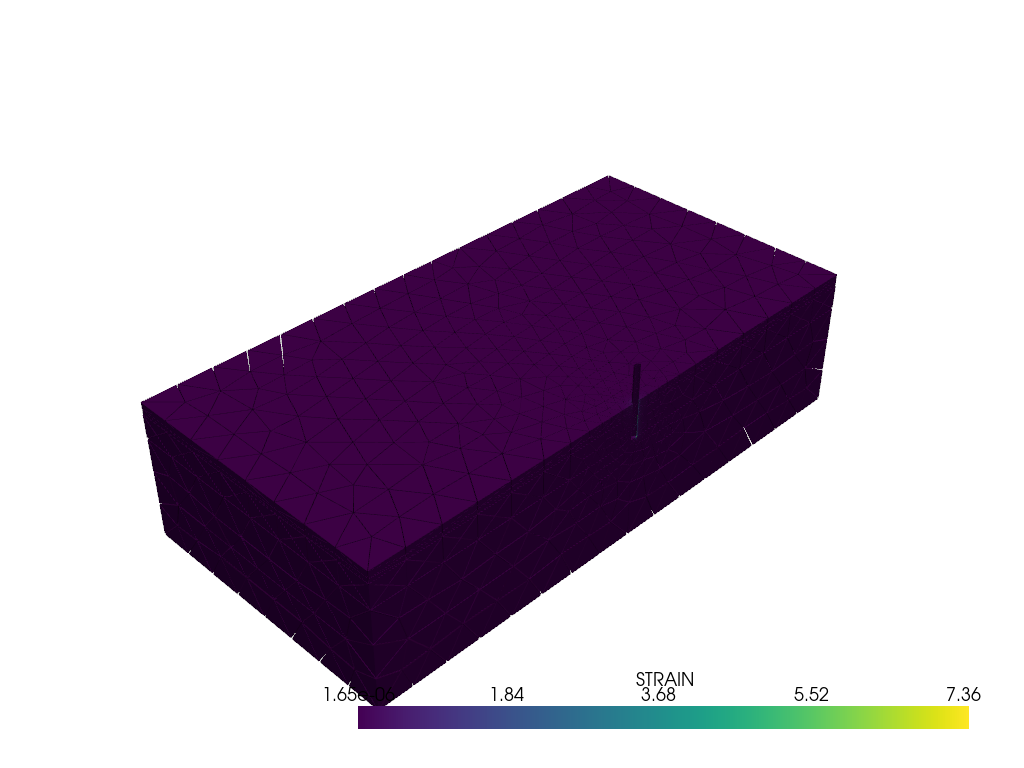

In [9]:
import pyvista as pv
pv.set_plot_theme("document")

from pyvirtualdisplay import Display
display = Display(backend="xvfb", visible=False, size=(1024, 768))
display.start()
vtk_files = subprocess.run(f"ls -c1 {params.data_dir}/*.vtk | sort -V", shell=True, text=True, capture_output=True)
if vtk_files.returncode == 0:
    files = [vtk_file for vtk_file in vtk_files.stdout.splitlines()]
    final_file = files[-1]
    mesh = pv.read(final_file)
    mesh=mesh.shrink(0.95) 
    warp_factor = 1.0
    # mesh = mesh.warp_by_vector(vectors="U", factor = warp_factor)
    # show_field = "STRESS"
    show_field = "STRAIN" # U: displacement
    # show_field = "STRAIN" # U: displacement
    # print(mesh.point_data)
    # if mesh.point_data[show_field].shape[1] > 3:
        # cmap = "Spectral"
    p = pv.Plotter(notebook=True)
    p.add_mesh(mesh, scalars=show_field)
    # p.camera_position = [(-10, 0, 10), (0.0, 0.0, 0.0), (0.0, 1.0, 0.0)]
    p.camera_position = 'iso'
    p.show(jupyter_backend='ipygany')

In [10]:
sys.exit()

SystemExit: 

/mofem_install/jupyter/thomas/.local/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# 7. Extract data from .vtk files 
Tools:
pvpython

In [12]:
if params:
    postprocessing_script = params.postprocessing_script
    data_dir = params.data_dir
else:
    postprocessing_script = "/mofem_install/jupyter/thomas/mfront_example_test/src/pile_postprocessing.py"
    data_dir = "/mofem_install/jupyter/thomas/mfront_example_test/simulations/day_39_sim_3_2024_09_25_18_50_27"
original_pythonpath = os.environ.get("PYTHONPATH", "")
os.environ["PYTHONPATH"] = ""
try:
    !/mofem_install/jupyter/thomas/ParaView-5.13.1-MPI-Linux-Python3.10-x86_64/bin/pvpython {postprocessing_script} {data_dir}
except Exception as e:
    print(e)
finally:
    os.environ["PYTHONPATH"] = original_pythonpath

╭───────────────────────────────────╮
│  EXTRACTING GROUP DATA FROM .vtk  │
╰───────────────────────────────────╯
Read Success
Done, taken Wall Time: 83.08 seconds, CPU Time: 98.64 seconds
╭─────────────────────────────╮
│  EXTRACTING DATA FROM .vtk  │
╰─────────────────────────────╯
Read Success
Done, taken Wall Time: 5.22 seconds, CPU Time: 11.18 seconds


# 8. Plotting
Tools:
Matplotlib

In [ ]:
import sys
sys.path.append('/mofem_install/jupyter/thomas/mfront_example_test/src')
import plotting
import custom_models as cm
data_dir = r"/mofem_install/jupyter/thomas/mfront_example_test/simulations/auto_LinearElasticity_d39_8_2024_09_25_22_16_19"
mode = params.mode if params else "auto"
# data_dir = r"/mofem_install/jupyter/thomas/mfront_example_test/simulations/manual_LinearElasticity_d39_7_2024_09_25_20_58_41"
# mode = "manual"
soil_model = cm.PropertyTypeEnum.elastic
suptitle = f"Mesh mode: {mode} | Behaviour: {soil_model.value}"

time_plot_config = plotting.PlotConfig(
    csv_files = {
        "1.2,0,0 (Compression)": f'{data_dir}/dis_to_time_compression_mudline_1.2.csv', 
        "1.1,0,0 (Compression)": f'{data_dir}/dis_to_time_compression_mudline_1.1.csv', 
        "1.0,0,0 (Compression)": f'{data_dir}/dis_to_time_compression_mudline_1.0.csv', 
     }, 
    output_dir = data_dir,
    suptitle = suptitle,
)

depth_plot_config = plotting.PlotConfig(
    csv_files = {
        "1.2,0,0 (Compression)": f'{data_dir}/dis_to_depth_compression_x_1.2.csv', 
        "1.1,0,0 (Compression)": f'{data_dir}/dis_to_depth_compression_x_1.1.csv', 
        "1.0,0,0 (Compression)": f'{data_dir}/dis_to_depth_compression_x_1.csv', 
     }, 
    output_dir = data_dir,
    suptitle = suptitle,
)

against_time_plotter = plotting.TimePlotter(time_plot_config)
against_depth_plotter = plotting.DepthPlotter(depth_plot_config)

sigvM_e = against_time_plotter.sigvM_e(save_as="sigvM_e.png")
J_p = against_time_plotter.J_p(save_as="J_p.png")

dispx_z = against_depth_plotter.plot_displacement_vs_depth(save_as="dispx_z.png")
sigxx_z = against_depth_plotter.sigxx_z(save_as="sigxx_z.png")
sigvM_z = against_depth_plotter.plot_von_mises_vs_depth(save_as="sigvM_z.png")
E_z = against_depth_plotter.E_z(save_as="E_z.png")

╭─────────────────────────────╮
│  PLOTTING sig_vM AGAINST e  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.15 seconds, CPU Time: 1.61 seconds
╭────────────────────────╮
│  PLOTTING J against p  │
╰────────────────────────╯
Done, taken Wall Time: 0.09 seconds, CPU Time: 0.09 seconds
╭─────────────────────────────╮
│  PLOTTING disp_x AGAINST z  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.10 seconds, CPU Time: 0.10 seconds
╭─────────────────────────────╮
│  PLOTTING sig_xx AGAINST z  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.09 seconds, CPU Time: 0.09 seconds
╭─────────────────────────────╮
│  PLOTTING sig_vM AGAINST z  │
╰─────────────────────────────╯
Done, taken Wall Time: 0.10 seconds, CPU Time: 0.10 seconds
╭────────────────────────╮
│  PLOTTING E AGAINST z  │
╰────────────────────────╯
Done, taken Wall Time: 0.11 seconds, CPU Time: 0.11 seconds


In [ ]:
from IPython.display import display, HTML

# Time-related images with a common title
display(HTML('<h3 style="text-align:left">Across Time Steps</h3>'))

image_files_time = [sigvM_e, J_p]
images_html_time = ''.join([
    f'<img src="{img}" style="display:inline;margin:1px" width="300"/>'
    for img in image_files_time
])
display(HTML(images_html_time))

# Depth-related images with a common title
display(HTML('<h3 style="text-align:elft">At the Final Time Step</h3>'))

image_files_depth = [dispx_z, sigxx_z, sigvM_z, E_z]
images_html_depth = ''.join([
    f'<img src="{img}" style="display:inline;margin:1px" width="300"/>'
    for img in image_files_depth
])
display(HTML(images_html_depth))